# Import packages

In [1]:
import sys
import func
import glob,os
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import numpy as np
from copy import deepcopy
import pandas as pd
from natsort import natsorted

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import math
import sklearn
from sklearn.linear_model import LinearRegression

In [14]:
! pwd

/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite


# Import training and validation data

In [3]:
origcyclone_dict = {}
origcyclonefilelist_f = natsorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/timeseries_csv/ts_wp/*'))[:]
for ind,obj in tqdm(enumerate(origcyclonefilelist_f)):
    origcyclone_dict['cyclone'+str(ind)] = func._process_dataset(obj).values

228it [00:08, 25.84it/s]


# Import test data

In [4]:
testcyclone_dict = {}
newtestfilelist_f = natsorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/timeseries_csv/new_storms_wpac/*'))[-62:-7]
for ind,obj in tqdm(enumerate(newtestfilelist_f)):
    testcyclone_dict['testcyclone'+str(ind)] = func._process_dataset(obj).values

55it [00:02, 24.56it/s]


# Align time series based on minimum MSLP during TC life cycle

## Find the minimum MSLP index

In [5]:
def minMSLPindex_todict(dictionary=None,smooth=3,pminINDEX=1):
    newddwp = {}
    indices = {}
    for inte,item in enumerate(dictionary.keys()):
        newddwp[inte] = dictionary[item]
    # Smooth the pmin time series to make it easier to identify life cycle min MSLP
    for ind,TCnames in enumerate(newddwp.keys()):
        indices[TCnames] = np.argmin(gaussian_filter1d(newddwp[TCnames][:,pminINDEX],smooth))
    return newddwp,indices

In [6]:
trainvalid_data,trainvalid_indices = minMSLPindex_todict(dictionary=origcyclone_dict,smooth=3,pminINDEX=1)
test_data,test_indices = minMSLPindex_todict(dictionary=testcyclone_dict,smooth=3,pminINDEX=1)

In [7]:
print(trainvalid_indices)

{0: 29, 1: 66, 2: 53, 3: 89, 4: 22, 5: 62, 6: 42, 7: 64, 8: 60, 9: 38, 10: 45, 11: 58, 12: 67, 13: 44, 14: 83, 15: 27, 16: 37, 17: 50, 18: 48, 19: 54, 20: 91, 21: 83, 22: 80, 23: 52, 24: 72, 25: 22, 26: 45, 27: 63, 28: 50, 29: 81, 30: 39, 31: 57, 32: 62, 33: 86, 34: 67, 35: 57, 36: 63, 37: 74, 38: 62, 39: 43, 40: 42, 41: 60, 42: 68, 43: 46, 44: 60, 45: 59, 46: 88, 47: 87, 48: 79, 49: 116, 50: 63, 51: 34, 52: 41, 53: 40, 54: 100, 55: 94, 56: 11, 57: 51, 58: 94, 59: 64, 60: 29, 61: 50, 62: 49, 63: 57, 64: 78, 65: 44, 66: 38, 67: 59, 68: 29, 69: 48, 70: 33, 71: 55, 72: 84, 73: 39, 74: 56, 75: 48, 76: 82, 77: 84, 78: 90, 79: 41, 80: 63, 81: 38, 82: 42, 83: 50, 84: 65, 85: 52, 86: 45, 87: 51, 88: 33, 89: 51, 90: 49, 91: 52, 92: 44, 93: 29, 94: 83, 95: 21, 96: 45, 97: 73, 98: 46, 99: 30, 100: 62, 101: 50, 102: 26, 103: 64, 104: 39, 105: 57, 106: 45, 107: 64, 108: 130, 109: 52, 110: 58, 111: 28, 112: 25, 113: 49, 114: 44, 115: 61, 116: 58, 117: 52, 118: 35, 119: 45, 120: 84, 121: 38, 122: 72,

# The fun begins: training the PC1 models

## Settings

In [8]:
#change your hyperparameters here, splitsize (for splitting to train and validation set)
splitsize=55
pc_type = 'run_pcstable'
var_names=func._process_dataset(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/timeseries_csv/ts_wp/'+'*2020chanhom*')[0]).columns.values.tolist()
tau_min = 8    
tau_max = 24
pc_alphaa = 0.00000001
seednum = 12345

## Aligning time series based on minimum MSLP during life cycles

In [9]:
def align_data(refpoint=None,individualpoint=None,data=None):
    newtraincyclone2 = np.zeros((data.shape[0]+(refpoint-individualpoint),data.shape[1]))
    for i in range((data.shape[1])):
        newtraincyclone2[:,i] = np.concatenate([np.ones((refpoint-individualpoint))*(-999.),data[:,i]])
    return newtraincyclone2

def output_aligned_data(data=None,indices=None):
    aligned_data = {}
    for intt,obj in enumerate(data.keys()):
        aligned_data[obj] = align_data(np.asarray(list(indices.values())).max(),indices[obj],data[obj])
    return aligned_data

## Causal Discovery with Tigramite; Processing MLR inputs with Causal Relations

In [10]:
aligned_trainvalid = output_aligned_data(trainvalid_data,trainvalid_indices)
aligned_test = output_aligned_data(test_data,test_indices)

for pc_alpha in ([pc_alphaa]):
    testindex = (func.Pipeline(aligned_trainvalid,pc_alpha,None,pc_type=pc_type,tau_min0=tau_min,tau_max0=tau_max,\
                          target=None,var_name=var_names,seed=seednum).random_testindex(205,splitsize))
    traindata,validdata1,validdata2 = func.Pipeline(aligned_trainvalid,pc_alpha,None,pc_type=pc_type,tau_min0=tau_min,tau_max0=tau_max,\
                                            target=None,var_name=var_names,seed=seednum).splitdata(testindex)
   
    testdata = deepcopy(aligned_test)
    result,val_min,pval_max = func.Pipeline(traindata,pc_alpha,None,pc_type=pc_type,tau_min0=tau_min,tau_max0=tau_max,\
                      target=None,var_name=var_names,seed=seednum).run_tigramite(int(205-splitsize))
    saveresults = {'result':result,'val_min':val_min,'pval_max':pval_max}
    var_and_lag = [result[0],result[1],result[2]]
     #Note: In our initial experiments, we had train, valid and testdata from the 205 TC cases. During analysis, we combined the validation and Test sets to validation set, 
        #later we added a newtestdata with similar no. of TCs as validation and hence we defined it below as newtestdata.
    validdata=func.do_num_to_nan(validdata1)
    testdata=func.do_num_to_nan(validdata2)
    newtestdata=func.do_num_to_nan(testdata)
    
    wpac_mlr_precip,X_precip,y_precip = func.trainMLR_target(traindata=traindata,validdata=validdata,testdata=testdata,newtestdata=testdata,pc_alpha=pc_alpha,\
                                                        alpha_level=None,tau_min0=tau_min,tau_max0=tau_max,target='precip',seed=seednum,var_and_lag=var_and_lag)
    wpac_mlr_pmin,X_pmin,y_pmin = func.trainMLR_target(traindata=traindata,validdata=validdata,testdata=testdata,newtestdata=testdata,pc_alpha=pc_alpha,\
                                                        alpha_level=None,tau_min0=tau_min,tau_max0=tau_max,target='pmin',seed=seednum,var_and_lag=var_and_lag)
    wpac_mlr_v10,X_v10,y_v10 = func.trainMLR_target(traindata=traindata,validdata=validdata,testdata=testdata,newtestdata=testdata,pc_alpha=pc_alpha,\
                                                        alpha_level=None,tau_min0=tau_min,tau_max0=tau_max,target='v10',seed=seednum,var_and_lag=var_and_lag)

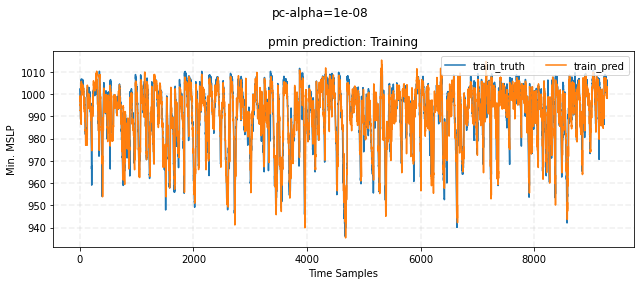

In [11]:
fig,ax = plt.subplots(1,1,figsize=(9,4))
plt.plot(y_pmin['train'],label='train_truth')
plt.plot(wpac_mlr_pmin.predict(X_pmin['train']),label='train_pred')
#plt.plot(pmin_trained[5]['mlr'].predict(pmin_trained[5]['X']['test']),label='train_pred')
ax.set_xlabel('Time Samples')
ax.set_ylabel('Min. MSLP')
ax.legend(loc=1,ncol=2)
ax.grid(alpha=0.2,lw=1.5,ls='--')
plt.suptitle(f'pc-alpha={pc_alpha}')
plt.title('pmin prediction: Training')
plt.tight_layout()
plt.show()

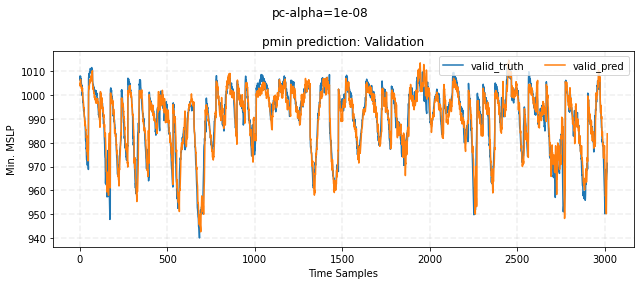

In [15]:
fig,ax = plt.subplots(1,1,figsize=(9,4))
plt.plot((y_pmin['valid']+y_pmin['test']),label='valid_truth')
plt.plot(wpac_mlr_pmin.predict(X_pmin['valid']+X_pmin['test']),label='valid_pred')
#plt.plot(pmin_trained[5]['mlr'].predict(pmin_trained[5]['X']['test']),label='train_pred')
ax.set_xlabel('Time Samples')
ax.set_ylabel('Min. MSLP')
ax.legend(loc=1,ncol=2)
ax.grid(alpha=0.2,lw=1.5,ls='--')
plt.suptitle(f'pc-alpha={pc_alpha}')
plt.title('pmin prediction: Validation')
plt.tight_layout()
plt.show()

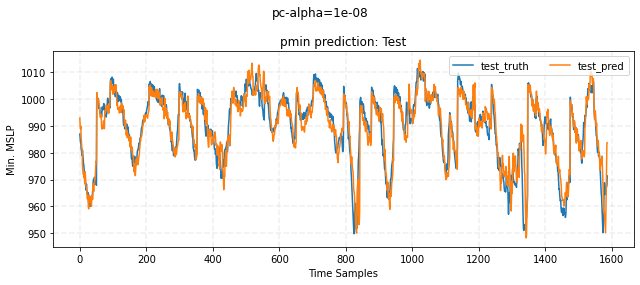

In [16]:
fig,ax = plt.subplots(1,1,figsize=(9,4))
plt.plot(y_pmin['newtest'],label='test_truth')
plt.plot(wpac_mlr_pmin.predict(X_pmin['newtest']),label='test_pred')
#plt.plot(pmin_trained[5]['mlr'].predict(pmin_trained[5]['X']['test']),label='train_pred')
ax.set_xlabel('Time Samples')
ax.set_ylabel('Min. MSLP')
ax.legend(loc=1,ncol=2)
ax.grid(alpha=0.2,lw=1.5,ls='--')
plt.suptitle(f'pc-alpha={pc_alpha}')
plt.title('pmin prediction: Test')
plt.tight_layout()
plt.show()